# Objectives:


* create a chatbot for farmers to inquire about weather and planting conditions for optimal crop planting weather/ seasons

## About this project:

#### EDA:

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



#### Processes:
* .head() - allows us to view the first five items iin the database
* .shape - shows us the rows and columns 
* .isna().sum() - calculates the colum valuse with null values
* .drop() - allows us to drop columns that are not being used to reduce clutter and improve useabillity
* .fillna(0) - replaces the null values with "0"
* .describe() - shows a statistical summary of the dataset


#### Kenya-weather-data-gyga-format:   LARGE FILE!!


In [2]:
weather_data = pd.read_excel('datasets/Kenya-weather-data-gyga-format.xlsx',sheet_name='Kenya')
weather_data.head()

,station_id,country,DOY,date,year,month,day,srad,tmax,tmin,...,srad_inf,tmin_inf,tmax_inf,rain_inf,rh_inf,wind_inf,vp_inf,tdew_inf,sunhrs_inf,et_inf
0,9000000,Kenya,1,1992-01-01,1992,1,1,23.0,23.9,11.3,...,gridded,observed,observed,observed,gridded,assumed constant,NaN,NaN,NaN,NaN
1,9000000,Kenya,2,1992-01-02,1992,1,2,23.0,26.1,13.1,...,gridded,observed,observed,observed,gridded,assumed constant,NaN,NaN,NaN,NaN
2,9000000,Kenya,3,1992-01-03,1992,1,3,22.0,26.0,12.6,...,gridded,observed,observed,observed,gridded,assumed constant,NaN,NaN,NaN,NaN
3,9000000,Kenya,4,1992-01-04,1992,1,4,21.0,25.0,12.6,...,gridded,observed,observed,observed,gridded,assumed constant,NaN,NaN,NaN,NaN
4,9000000,Kenya,5,1992-01-05,1992,1,5,27.0,22.4,12.2,...,gridded,observed,observed,observed,gridded,assumed constant,NaN,NaN,NaN,NaN


In [3]:
weather_data.shape

(136235, 27)

In [4]:
weather_data.isna().sum()

station_id         0
country            0
DOY                0
date               0
year               0
month              0
day                0
srad               0
tmax               0
tmin               0
rain               0
rh                 0
wind           15355
vp            136235
tdew          136235
sunhrs        136235
et            136235
srad_inf           0
tmin_inf           0
tmax_inf           0
rain_inf           0
rh_inf             0
wind_inf       15355
vp_inf        136235
tdew_inf      136235
sunhrs_inf    136235
et_inf        136235
dtype: int64

In [5]:
#dropping null columns to clean the data and reduce unecessary columns
weather_data= weather_data.drop(columns=["srad_inf", "tmin_inf", "tmax_inf", "rain_inf", "rh_inf", "wind_inf", "vp_inf", "tdew_inf", "sunhrs_inf", "et_inf", "wind", "vp", "tdew", "sunhrs", "et"])
weather_data.isna().sum()

station_id    0
country       0
DOY           0
date          0
year          0
month         0
day           0
srad          0
tmax          0
tmin          0
rain          0
rh            0
dtype: int64

In [6]:
weather_data.head()

,station_id,country,DOY,date,year,month,day,srad,tmax,tmin,rain,rh
0,9000000,Kenya,1,1992-01-01,1992,1,1,23.0,23.9,11.3,0.0,57.0
1,9000000,Kenya,2,1992-01-02,1992,1,2,23.0,26.1,13.1,0.0,44.0
2,9000000,Kenya,3,1992-01-03,1992,1,3,22.0,26.0,12.6,0.0,45.0
3,9000000,Kenya,4,1992-01-04,1992,1,4,21.0,25.0,12.6,0.0,49.0
4,9000000,Kenya,5,1992-01-05,1992,1,5,27.0,22.4,12.2,0.0,43.0


#### Temperature change on land:

In [7]:
tempreature_change = pd.read_csv('datasets/Temperature change on land.csv')
tempreature_change.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,2000,2000,°c,0.208,E,Estimated value
1,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,2001,2001,°c,0.476,E,Estimated value
2,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,2002,2002,°c,1.026,E,Estimated value
3,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,2003,2003,°c,0.797,E,Estimated value
4,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,2004,2004,°c,1.240,E,Estimated value


In [8]:
tempreature_change.shape

(600, 14)

In [9]:
tempreature_change = tempreature_change.drop(columns=["Domain Code", "Element Code", "Domain", "Area Code (M49)", "Area", "Months Code", "Year Code", "Flag", "Flag Description"])
tempreature_change.head()

,Element,Months,Year,Unit,Value
0,Temperature change,January,2000,°c,0.208
1,Temperature change,January,2001,°c,0.476
2,Temperature change,January,2002,°c,1.026
3,Temperature change,January,2003,°c,0.797
4,Temperature change,January,2004,°c,1.240


In [10]:
tempreature_change.describe()

,Year,Value
count,600.000000,600.000000
mean,2012.000000,0.727012
std,7.217119,0.467588
min,2000.000000,-0.813000
25%,2006.000000,0.372000
50%,2012.000000,0.469000
75%,2018.000000,1.015250
max,2024.000000,2.915000


In [11]:
tempreature_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Element  600 non-null    object 
 1   Months   600 non-null    object 
 2   Year     600 non-null    int64  
 3   Unit     600 non-null    object 
 4   Value    600 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 23.6+ KB


In [12]:
tempreature_change.isna().sum()

Element    0
Months     0
Year       0
Unit       0
Value      0
dtype: int64

#### Crops and livestock products:

In [13]:
products = pd.read_csv('datasets/Crops and livestock products.csv')
products.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,404,Kenya,5312,Area harvested,1929.07,"Abaca, manila hemp, raw",2000,2000,ha,26.0,E,Estimated value,NaN
1,QCL,Crops and livestock products,404,Kenya,5412,Yield,1929.07,"Abaca, manila hemp, raw",2000,2000,kg/ha,1153.8,E,Estimated value,NaN
2,QCL,Crops and livestock products,404,Kenya,5510,Production,1929.07,"Abaca, manila hemp, raw",2000,2000,t,30.0,E,Estimated value,NaN
3,QCL,Crops and livestock products,404,Kenya,5312,Area harvested,1929.07,"Abaca, manila hemp, raw",2001,2001,ha,29.0,E,Estimated value,NaN
4,QCL,Crops and livestock products,404,Kenya,5412,Yield,1929.07,"Abaca, manila hemp, raw",2001,2001,kg/ha,1156.6,E,Estimated value,NaN


In [14]:
products.shape

(6126, 15)

In [15]:
products.isna().sum()

Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Element Code           0
Element                0
Item Code (CPC)        0
Item                   0
Year Code              0
Year                   0
Unit                   0
Value                 78
Flag                   0
Flag Description       0
Note                6029
dtype: int64

In [16]:
products = products.drop(columns=["Domain Code", "Area Code (M49)", "Area", "Element Code", "Item Code (CPC)",  "Year Code", "Flag", "Flag Description", "Note"])
products.head()

,Domain,Element,Item,Year,Unit,Value
0,Crops and livestock products,Area harvested,"Abaca, manila hemp, raw",2000,ha,26.0
1,Crops and livestock products,Yield,"Abaca, manila hemp, raw",2000,kg/ha,1153.8
2,Crops and livestock products,Production,"Abaca, manila hemp, raw",2000,t,30.0
3,Crops and livestock products,Area harvested,"Abaca, manila hemp, raw",2001,ha,29.0
4,Crops and livestock products,Yield,"Abaca, manila hemp, raw",2001,kg/ha,1156.6


In [17]:
products.isna().sum()

Domain      0
Element     0
Item        0
Year        0
Unit        0
Value      78
dtype: int64

In [18]:
products = products.fillna(0)
products.head()

,Domain,Element,Item,Year,Unit,Value
0,Crops and livestock products,Area harvested,"Abaca, manila hemp, raw",2000,ha,26.0
1,Crops and livestock products,Yield,"Abaca, manila hemp, raw",2000,kg/ha,1153.8
2,Crops and livestock products,Production,"Abaca, manila hemp, raw",2000,t,30.0
3,Crops and livestock products,Area harvested,"Abaca, manila hemp, raw",2001,ha,29.0
4,Crops and livestock products,Yield,"Abaca, manila hemp, raw",2001,kg/ha,1156.6


In [19]:
products.isna().sum()

Domain     0
Element    0
Item       0
Year       0
Unit       0
Value      0
dtype: int64

In [20]:
products.describe()

,Year,Value
count,6126.000000,6.126000e+03
mean,2011.520568,1.067654e+05
std,6.927177,4.808814e+05
min,2000.000000,0.000000e+00
25%,2006.000000,9.393850e+02
50%,2012.000000,6.306750e+03
75%,2018.000000,2.491375e+04
max,2023.000000,8.799800e+06


In [21]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6126 entries, 0 to 6125
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   6126 non-null   object 
 1   Element  6126 non-null   object 
 2   Item     6126 non-null   object 
 3   Year     6126 non-null   int64  
 4   Unit     6126 non-null   object 
 5   Value    6126 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 287.3+ KB


#### Cropland Nutrient Balance:

In [22]:
land_nutrients = pd.read_csv('datasets/Cropland Nutrient Balance.csv')
land_nutrients.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,ESB,Cropland Nutrient Balance,404,Kenya,7276,Cropland nitrogen per unit area,5079,Input,2000,2000,kg/ha,34.0132,E,Estimated value,NaN
1,ESB,Cropland Nutrient Balance,404,Kenya,7281,Cropland phosphorus per unit area,5079,Input,2000,2000,kg/ha,7.1153,E,Estimated value,NaN
2,ESB,Cropland Nutrient Balance,404,Kenya,7283,Cropland potassium per unit area,5079,Input,2000,2000,kg/ha,9.1238,E,Estimated value,NaN
3,ESB,Cropland Nutrient Balance,404,Kenya,7276,Cropland nitrogen per unit area,5079,Input,2001,2001,kg/ha,34.5876,E,Estimated value,NaN
4,ESB,Cropland Nutrient Balance,404,Kenya,7281,Cropland phosphorus per unit area,5079,Input,2001,2001,kg/ha,6.6819,E,Estimated value,NaN


In [23]:
land_nutrients.isna().sum()

Domain Code           0
Domain                0
Area Code (M49)       0
Area                  0
Element Code          0
Element               0
Item Code             0
Item                  0
Year Code             0
Year                  0
Unit                  0
Value                 0
Flag                  0
Flag Description      0
Note                138
dtype: int64

In [24]:
land_nutrients = land_nutrients.drop(columns=["Domain Code", "Area Code (M49)", "Area", "Element Code", "Item Code", "Year Code","Flag", "Flag Description", "Note"])
land_nutrients.head()

,Domain,Element,Item,Year,Unit,Value
0,Cropland Nutrient Balance,Cropland nitrogen per unit area,Input,2000,kg/ha,34.0132
1,Cropland Nutrient Balance,Cropland phosphorus per unit area,Input,2000,kg/ha,7.1153
2,Cropland Nutrient Balance,Cropland potassium per unit area,Input,2000,kg/ha,9.1238
3,Cropland Nutrient Balance,Cropland nitrogen per unit area,Input,2001,kg/ha,34.5876
4,Cropland Nutrient Balance,Cropland phosphorus per unit area,Input,2001,kg/ha,6.6819


In [25]:
land_nutrients["Item"].value_counts()

Input      69
Outputs    69
Name: Item, dtype: int64

#### Land Use:

In [26]:
land_use = pd.read_csv('datasets/Land Use.csv')
land_use.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RL,Land Use,404,Kenya,5110,Area,6600,Country area,2000,2000,1000 ha,58037.0,A,Official figure,NaN
1,RL,Land Use,404,Kenya,5110,Area,6600,Country area,2001,2001,1000 ha,58037.0,A,Official figure,NaN
2,RL,Land Use,404,Kenya,5110,Area,6600,Country area,2002,2002,1000 ha,58037.0,A,Official figure,NaN
3,RL,Land Use,404,Kenya,5110,Area,6600,Country area,2003,2003,1000 ha,58037.0,A,Official figure,NaN
4,RL,Land Use,404,Kenya,5110,Area,6600,Country area,2004,2004,1000 ha,58037.0,I,Imputed value,NaN


In [27]:
land_use.isna().sum()

Domain Code           0
Domain                0
Area Code (M49)       0
Area                  0
Element Code          0
Element               0
Item Code             0
Item                  0
Year Code             0
Year                  0
Unit                  0
Value                 0
Flag                  0
Flag Description      0
Note                230
dtype: int64

In [28]:
land_use = land_use.drop(columns=["Domain Code", "Area Code (M49)", "Area", "Element Code", "Item Code", "Year Code", "Flag", "Flag Description", "Note"])
land_use.head()

,Domain,Element,Item,Year,Unit,Value
0,Land Use,Area,Country area,2000,1000 ha,58037.0
1,Land Use,Area,Country area,2001,1000 ha,58037.0
2,Land Use,Area,Country area,2002,1000 ha,58037.0
3,Land Use,Area,Country area,2003,1000 ha,58037.0
4,Land Use,Area,Country area,2004,1000 ha,58037.0


In [29]:
land_use.isna().sum()

Domain     0
Element    0
Item       0
Year       0
Unit       0
Value      0
dtype: int64

In [30]:
land_use.describe()

,Year,Value
count,230.000000,230.000000
mean,2011.217391,17797.633196
std,6.949327,22593.855254
min,2000.000000,0.135000
25%,2005.000000,23.877500
50%,2011.000000,3020.681100
75%,2017.000000,28428.743025
max,2023.000000,59196.900000


In [31]:
land_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   230 non-null    object 
 1   Element  230 non-null    object 
 2   Item     230 non-null    object 
 3   Year     230 non-null    int64  
 4   Unit     230 non-null    object 
 5   Value    230 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.9+ KB


# geospacial data


In [32]:
temperature = pd.read_csv("geological_data/Temperature at 2 Meters.csv")
temperature.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,T2M,2000,-0.5,33.750,25.78,25.78,25.38,25.16,24.97,24.03,23.77,23.81,24.83,24.07,23.67,24.42,24.64
1,T2M,2000,-0.5,34.375,25.47,26.00,25.88,25.25,24.98,24.32,23.70,23.81,24.64,23.95,23.38,23.32,24.55
2,T2M,2000,-0.5,35.000,22.27,23.08,23.30,22.20,21.69,20.57,19.77,20.22,20.98,21.17,20.69,20.35,21.35
3,T2M,2000,-0.5,35.625,16.31,16.87,17.85,16.67,16.10,14.53,13.67,13.92,14.82,15.54,15.43,15.53,15.60
4,T2M,2000,-0.5,36.250,16.61,17.30,18.35,17.05,16.40,14.83,14.02,14.03,15.12,15.88,15.89,16.53,16.00


In [33]:
precipitation = pd.read_csv("geological_data/precipitation average.csv")
precipitation.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,PRECTOTCORR,2000,-0.5,33.750,1.13,2.06,2.72,5.89,4.43,1.57,2.20,3.88,4.42,5.99,6.88,6.28,3.96
1,PRECTOTCORR,2000,-0.5,34.375,0.71,1.84,2.26,4.04,2.91,1.38,1.70,2.69,3.31,5.87,5.48,6.72,3.25
2,PRECTOTCORR,2000,-0.5,35.000,0.62,1.47,2.17,3.31,2.45,1.41,1.93,2.52,2.88,4.96,5.64,5.19,2.88
3,PRECTOTCORR,2000,-0.5,35.625,0.33,0.65,1.36,2.90,1.74,1.45,2.45,3.29,2.55,3.26,4.95,2.52,2.29
4,PRECTOTCORR,2000,-0.5,36.250,0.30,0.30,0.88,2.47,1.39,1.42,2.45,3.45,2.15,2.10,3.74,1.86,1.88


In [34]:
Soil_Wetness = pd.read_csv("geological_data/Zone Soil Wetness (surface to 100 cm below).csv")
Soil_Wetness.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,GWETROOT,2000,-0.5,34.375,0.56,0.52,0.52,0.56,0.57,0.54,0.53,0.54,0.54,0.61,0.69,0.77,0.58
1,GWETROOT,2000,-0.5,35.000,0.51,0.48,0.49,0.51,0.51,0.49,0.49,0.50,0.51,0.54,0.60,0.65,0.52
2,GWETROOT,2000,-0.5,35.625,0.43,0.41,0.41,0.43,0.43,0.42,0.43,0.45,0.45,0.45,0.48,0.47,0.44
3,GWETROOT,2000,-0.5,36.250,0.38,0.37,0.36,0.39,0.38,0.38,0.39,0.41,0.41,0.40,0.42,0.40,0.39
4,GWETROOT,2000,-0.5,36.875,0.40,0.37,0.36,0.39,0.38,0.37,0.38,0.39,0.39,0.38,0.41,0.41,0.39


# PROCESSING GEOJSON FILES:


In [1]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade fiona


Requirement already up-to-date: fiona in c:\users\ericg\anaconda3\envs\learn-env\lib\site-packages (1.10.1)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade fiona


Requirement already up-to-date: fiona in c:\users\ericg\anaconda3\envs\learn-env\lib\site-packages (1.10.1)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import fiona
print(fiona.__version__)


1.10.1


In [12]:
pip install rasterio


Note: you may need to restart the kernel to use updated packages.


In [14]:
import geopandas as gpd
import rasterio
rasterio.__version__

'1.3.11'

## Reading files


#### Creating a function to help load data quicker and take up less space

In [44]:
def processing_data(filepath):
    data = rasterio.open(filepath)
    print(data)
    array_data = data.read()
    print(f"this is an array of the data {array_data}")
    print(f"this is the data information on the image {data.meta}")

    show(data)
    show_hist(data, bins=5, title='histogram')
    
    

<open DatasetReader name='ksa_data/Kenya Crop Mask 2019.tiff' mode='r'>
this is an array of the data [[[2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 1013, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


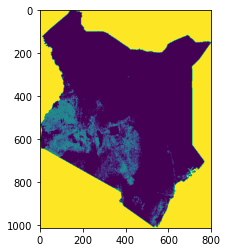

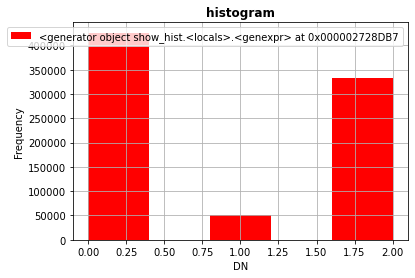

In [51]:
processing_data("ksa_data/Kenya Crop Mask 2019.tiff")

<open DatasetReader name='ksa_data/Kenya NDVI 2022.tiff' mode='r'>
this is an array of the data [[[253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  ...
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 1013, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


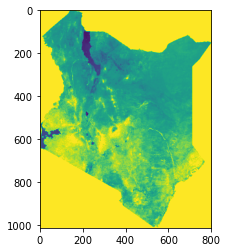

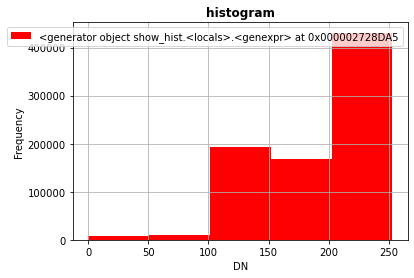

In [45]:
processing_data("ksa_data/Kenya NDVI 2022.tiff")

<open DatasetReader name='ksa_data/Kenya Soil Degradation Data.tiff' mode='r'>
this is an array of the data [[[249 249 249 ... 249 249 249]
  [249 249 249 ... 249 249 249]
  [249 249 249 ... 249 249 249]
  ...
  [249 249 249 ... 249 249 249]
  [249 249 249 ... 249 249 249]
  [249 249 249 ... 249 249 249]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 1010, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


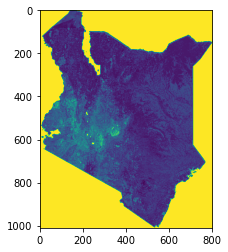

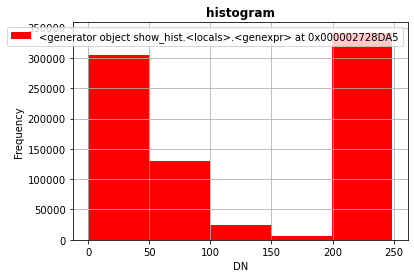

In [46]:
processing_data("ksa_data/Kenya Soil Degradation Data.tiff")

<open DatasetReader name='ksa_data/Kenya Soil Texture Types.tiff' mode='r'>
this is an array of the data [[[253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  ...
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]
  [253 253 253 ... 253 253 253]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 1010, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


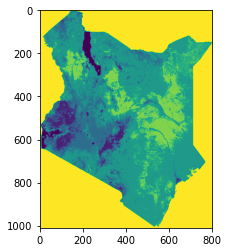

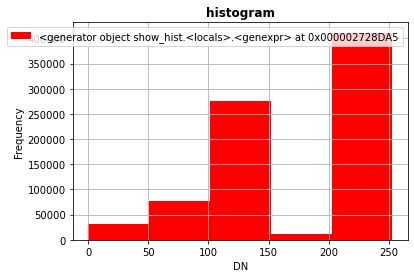

In [47]:
processing_data("ksa_data/Kenya Soil Texture Types.tiff")

<open DatasetReader name='ksa_data/Kenya_CropType_EndOfSeason_LongRains_2021.tiff' mode='r'>
this is an array of the data [[[10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  ...
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 602, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


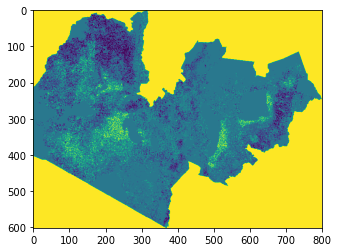

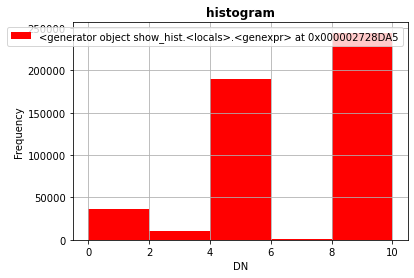

In [48]:
processing_data("ksa_data/Kenya_CropType_EndOfSeason_LongRains_2021.tiff")

<open DatasetReader name='ksa_data/Kenya_CropType_EndOfSeason_LongRains_2023.tiff' mode='r'>
this is an array of the data [[[10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  ...
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 751, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


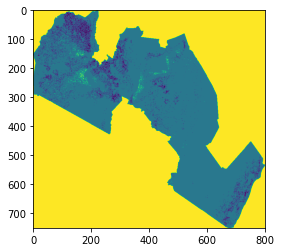

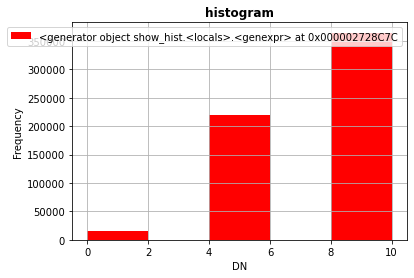

In [49]:
processing_data("ksa_data/Kenya_CropType_EndOfSeason_LongRains_2023.tiff")

<open DatasetReader name='ksa_data/Kenya_CropType_InSeason_ShortRains_2022-2023.tiff' mode='r'>
this is an array of the data [[[10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  ...
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]
  [10 10 10 ... 10 10 10]]]
this is the data information on the image {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 800, 'height': 751, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


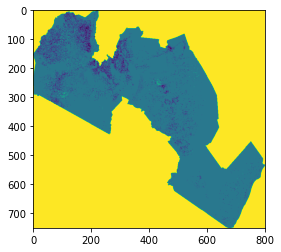

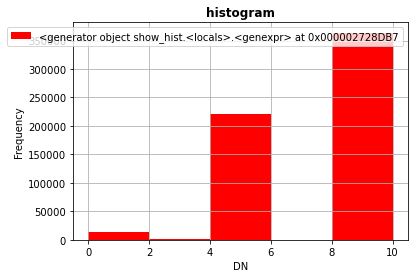

In [50]:
processing_data("ksa_data/Kenya_CropType_InSeason_ShortRains_2022-2023.tiff")

A DN value in an NDVI raster might correspond to vegetation index levels (e.g. greener = higher DN)

In a crop mask, DN values could represent presence or absence of crops or specific crop types

For soil or degradation maps, different DNs might map to soil classes or condition levels